<a href="https://colab.research.google.com/github/tjann/api-python/blob/internnotebooks/notebooks/Missing_Data_Imputation_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2020 Google LLC.
SPDX-License-Identifier: Apache-2.0

Author: Mahsa Eftekhari

# Time Series Holes: A Case Study Using Data Commons

In this notebook, we will examine types of missing values in time series and methods of imputing those values. Missing values might happen during data collection, or may be intentionally introduced during processing. Data scientists often impute missing values before using time series for analysis and machine learning.

First, we will survey random statistical variables from Data Commons and visualize their time series for a few counties. This will give us an understanding of the types of time series holes that exist.

Then, we will impute missing values using Pandas imputation methods that the [scipy.interpolate](https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html) package provides.


**To use this notebook, click on 'Runtime' and select 'Run all'**.

In [1]:
#@title Technical details: sampling function
#
#
#@markdown This section contains the functions that we use to retrieve data from Data Commons. We use  
#@markdown [**`build_time_series_dataframe`**](https://docs.datacommons.org/api/pandas/time_series.html) 
#@markdown to access the data for each sampled statistical variable. 
#
#@markdown **To reveal the hidden code double click on this section.**
#


"""
The function input are the total sampled statistical variables and a boolean flag for 
plot/not plot the sampled statistical variables. To avoid value errors for statistical variables 
with no data for our selected state we use try/except. 
"""
def select_random_statvars(sample_size, plot_flag, log_p):
  prov = pd.DataFrame(dc.get_property_values(["StatisticalVariable"], "typeOf", out =False, limit =500))

  chosen_idx = np.random.choice(len(prov.index), replace=False, size=sample_size)
  df_trimmed = prov.iloc[chosen_idx]
  allstatvars = set(df_trimmed['StatisticalVariable'])
  pltstats =[]

  # Comment the following line if you want to include all statistical variables:
  allstatvars = [x for x in allstatvars if not (x.startswith("dc/"))]

  geoids = (dc.get_places_in([_PLACE], "County"))[_PLACE]

  """
  For each statistical variable, a column represents a county (e.g. counties contained in California). 
  We select time series with at least four data points, at least four complete counties, and at least 
  four missing values. You can change the threshold by setting another value to *threshold*.
  """
  for statvar in allstatvars:
    try:
      data = dc.build_time_series_dataframe(geoids, statvar)

      # Get all state names and store it in a column "name"
      # Get the first name, if there are multiple for a state
      data.insert(0, 'name', data.index.map(dc.get_property_values(data.index, 'name')).str[0])
      data.set_index('name', inplace=True)
      data = data.transpose()

      data.dropna(axis=0, how='all', inplace=True)

      notNaColumns = data.columns[data.notna().all()].tolist()
      naColumns = data.columns[data.isnull().any()].tolist()
        
      threshold = 4
      if (len(naColumns) > threshold and len(notNaColumns)> threshold and data.size> threshold):
        if (plot_flag):
          plt = data[naColumns].plot(style=['bo-', 'o-', 'ro-'], figsize=(22, 10));
          plt.set_ylabel(statvar, fontsize=14)
          plt.set_xlabel('Date', fontsize=14)
        pltstats.append(statvar)
    except ValueError as e:
      if (log_p):
        print(statvar, ': No data for', _PLACE)
      
  return pltstats

In [2]:
#@title Technical details: validation
#
#
#@markdown In this section, we explain the implementation details of the cross-validation function for technical readers. 
#
#@markdown **To reveal the hidden code double click on this section.**
#
#

"""
The *artificial_score_generator* retrieves data using *build_time_series_dataframe* for each statistical variable.
It calls the *multiple_rounds_score_validation* to compute a matrix of R2 scores for each method and statistical 
variable. 
"""

def artificial_score_generator(rand_st, quiet=False):
  if (len(rand_st) < 1):
    print("run select_random_statvars again")
    return

  geoids = (dc.get_places_in([_PLACE], "County"))[_PLACE]
  all_scores = pd.DataFrame()
  i = -1
  for sv in rand_st:
    i += 1
    data = dc.build_time_series_dataframe(geoids, sv).transpose()
    data.reset_index(level=0, inplace=True)
    data.dropna(axis=1, how='all', inplace=True)
    data['index'] = pd.to_datetime(data['index'])
    data.set_index('index', inplace=True)

    current_scores = multiple_rounds_cross_validation(data, 20, sv, quiet)
    # Cap negative values at -100.
    current_scores.iloc[:, 1:2] = current_scores.iloc[:, 1:2].apply(lambda x: [y if y > -100 else -101 for y in x])
    if i > 0:
      all_scores = all_scores.merge(current_scores, on='method', how='left')
    else:
      all_scores = current_scores
    
  return all_scores

"""
*multiple_rounds_score_validation* function calls *one_round_cross_validation()* for 
(rounds =) 20 times. In each round, the *one_round_cross_validation()* removes data points 
*independently and uniformly at random* and calls *_FillwithX()* to impute the SAME set of missing 
data points with each method from the set *_METHODS* that we defined earlier. 
To generate a normalized result, we report the average of calculated scores.
"""

def multiple_rounds_cross_validation(df, rounds, stvar, quiet=False):
  notNaColumns = df.columns[df.notna().all()].tolist()
  multiple_rsquared_values = one_round_cross_validation(df, stvar, quiet)
  cols = multiple_rsquared_values.columns.difference(['method'])
  for round in range(rounds-1):
    multiple_rsquared_values[cols] = multiple_rsquared_values[cols].add(one_round_cross_validation(df, stvar, quiet)[cols])
    
  multiple_rsquared_values[cols] = multiple_rsquared_values[cols]/rounds
  ave = 'Average of %s rounds for %s'%(rounds, stvar)
  multiple_rsquared_values[ave]=multiple_rsquared_values.mean(axis=1,skipna=True)
  multiple_rsquared_values.sort_values(by=ave, inplace = True, ascending=False)
  return multiple_rsquared_values[['method',ave]].round(3) 

def one_round_cross_validation(df, sv, quiet=False):
  rsquared_df = pd.DataFrame({'method': pd.Series(_METHODS)})
  notNaColumns = df.columns[df.notna().all()].tolist()
  df = df[notNaColumns]

  # Make a copy of each column and randomly delete values from original columns:
  for col in notNaColumns:
    df[col+"_ref"] = df[col].copy()
    df[col] = df[col].sample(frac=0.8)

  for col in notNaColumns:
    _FillwithX(df, col, sv, quiet)
    result = []
    # scoring the result and see which is better
    for m in _METHODS:
      r2 = -100
      try:
        r2 = r2_score(df[col+'_ref'], df["Fill"+m+"_"+col])
      except ValueError as e:
        warnings.warn("r2 returns large negative value for %s :" %m)
      result += [(m, r2)]
    
    rsquared_df["r2_"+col] = pd.DataFrame(result, columns=['Method', 'R_squared'])['R_squared'].copy()
    rsquared_df["r2_"+col] = pd.to_numeric(rsquared_df["r2_"+col])
  return rsquared_df 


def _FillwithX(df, geo, sv, quiet=False):
  for meth in _METHODS:
    method = "Fill"+meth+"_"+geo
    try:
        if (meth == 'Mean'):
          df[method] = df[geo].fillna(df[geo].mean())
        elif (meth == 'Median'):
          df[method] = df[geo].fillna(df[geo].median()).bfill()
        elif (meth == 'Spline_d1'):
          df[method] = df[geo].interpolate(method='spline', order=1).bfill()
        elif (meth == 'Spline_d2'):
          df[method] = df[geo].interpolate(method='spline', order=2).bfill()
        elif (meth == 'Spline_d3'):
          df[method] = df[geo].interpolate(method='spline', order=3).bfill()
        elif (meth == 'Spline_d4'):
          df[method] = df[geo].interpolate(method='spline', order=4).bfill()
        elif (meth == 'Spline_d5'):
          df[method] = df[geo].interpolate(method='spline', order=5).bfill()
        elif (meth == 'InterpolateLinear'):
          df[method] = df[geo].interpolate(method='linear').bfill()
        elif (meth == 'Time'):
          df[method] = df[geo].interpolate(method='time').bfill()
        elif (meth == 'InterpolateAkima'):
          df[method] = df[geo].interpolate(method='akima', order=2).bfill()
        elif (meth == 'InterpolateSLinear'):
          df[method] = df[geo].interpolate(method='slinear').bfill()
        elif (meth == 'InterpolatePoly5'):
          df[method] = df[geo].interpolate(method='polynomial', order=2).bfill()
        elif (meth == 'InterpolatePoly7'):
          df[method] = df[geo].interpolate(method='polynomial', order=7).bfill()
        elif (meth == 'Krogh'):
          df[method] = df[geo].interpolate(method='krogh').bfill()
        elif (meth == 'Pchip'):
          df[method] = df[geo].interpolate(method='pchip').bfill()
    except:
        if not quiet:
          print(meth, "imputation raised error for ", sv, " filled missing value with zero instead!")
        df[method] = df[geo].fillna(0, inplace=True)  
  return df

In [3]:
# from google.colab import auth
# auth.authenticate_user()

# Import the required libraries
import pandas as pd
import random

!pip install datacommons --upgrade --quiet
import datacommons_pandas as dc

# Import other required libraries
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
import matplotlib.patches as mpatches

# Import a scoring metric to compare methods
from sklearn.metrics import r2_score
# %matplotlib inline

import numpy as np

import warnings

states = pd.DataFrame(dc.get_places_in(['country/USA'], 'State')['country/USA'])
states.insert(0, 'name', states[0].map(dc.get_property_values(states[0], 'name')).str[0])

# Part 1: Sample random statistical variables

In the following block, we will query Data Commons for the time series of 300 statistical variables for your selected state (defaults to California). Then, we will explore the datasets for all counties inside the state and plot the times series that are available for at least 4 counties. In **`select_random_statvars(sample_size, plot_flag, print_flag)`**, you can alter the plot_flag and print_flag to hide the plots and print logs respectively. The third option will let you see the sampled statistical variables with no data within the selected place. 

**Note:** For visual purposes, we include dots for a maximum of 3 lines. We use plain lines if there are more than 3 counties to plot. 

Number of valid samples:  14 ['Count_Establishment_PrivatelyOwnedEstablishment_NAICSHealthCareSocialAssistance', 'Count_Death_55To64Years_ExternalCauses', 'Count_Death_Female_BlackOrAfricanAmerican', 'ReceiptsOrRevenue_Establishment_NAICSEducationalServices_WithPayroll', 'Count_Death_45To54Years_ExternalCauses', 'WagesTotal_Worker_LocalGovernmentOwnedEstablishment_NAICSPublicAdministration', 'WagesTotal_Worker_StateGovernmentOwnedEstablishment_NAICSServiceProviding', 'WagesTotal_Worker_NAICSAdministrativeSupportWasteManagementRemediationServices', 'Count_Death_DiseasesOfTheDigestiveSystem_Male_White', 'WagesAnnual_Establishment_NAICSInformation', 'Count_Death_55To64Years_Neoplasms_BlackOrAfricanAmerican', 'Count_Death_55To64Years_ExternalCauses_White', 'Count_Death_65To74Years_Female_White', 'Count_Worker_PrivatelyOwnedEstablishment_NAICSEducationalServices']


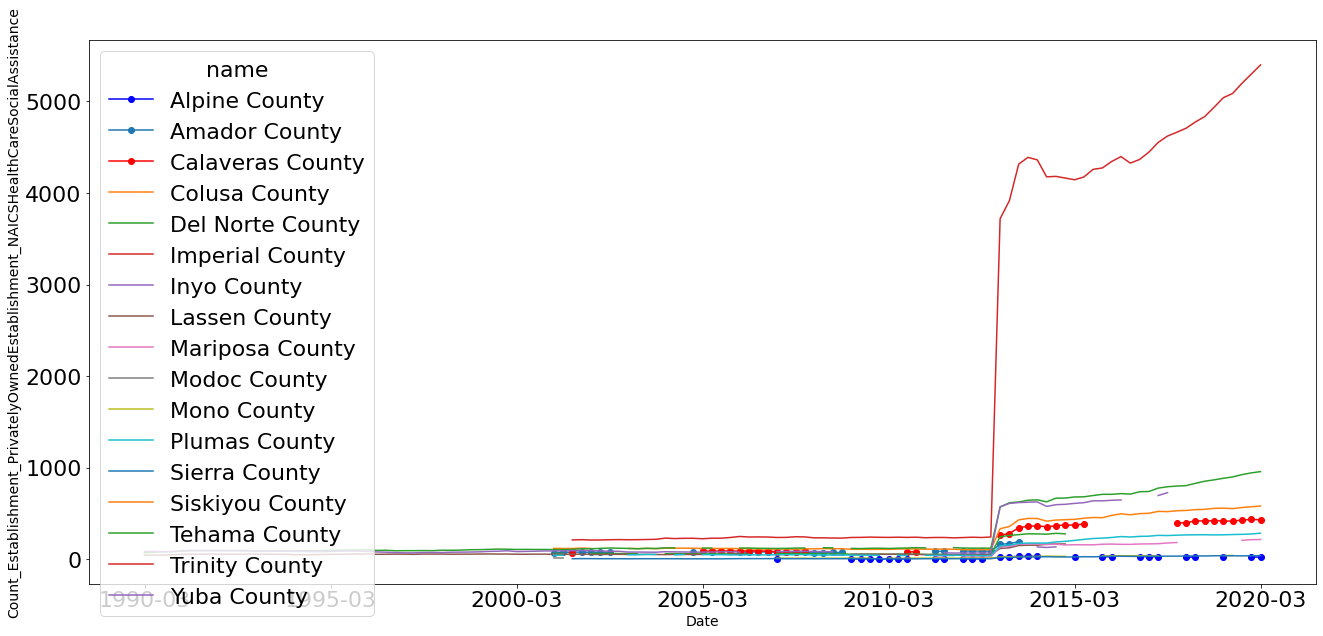

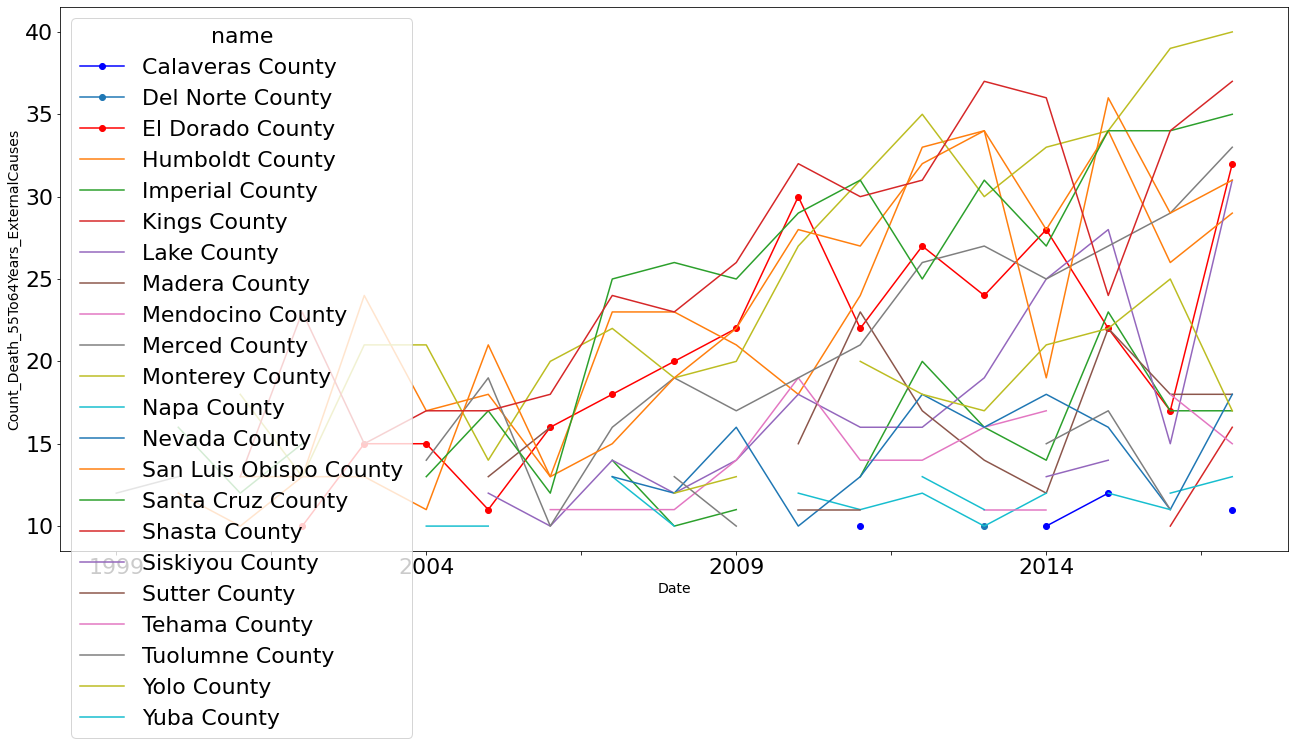

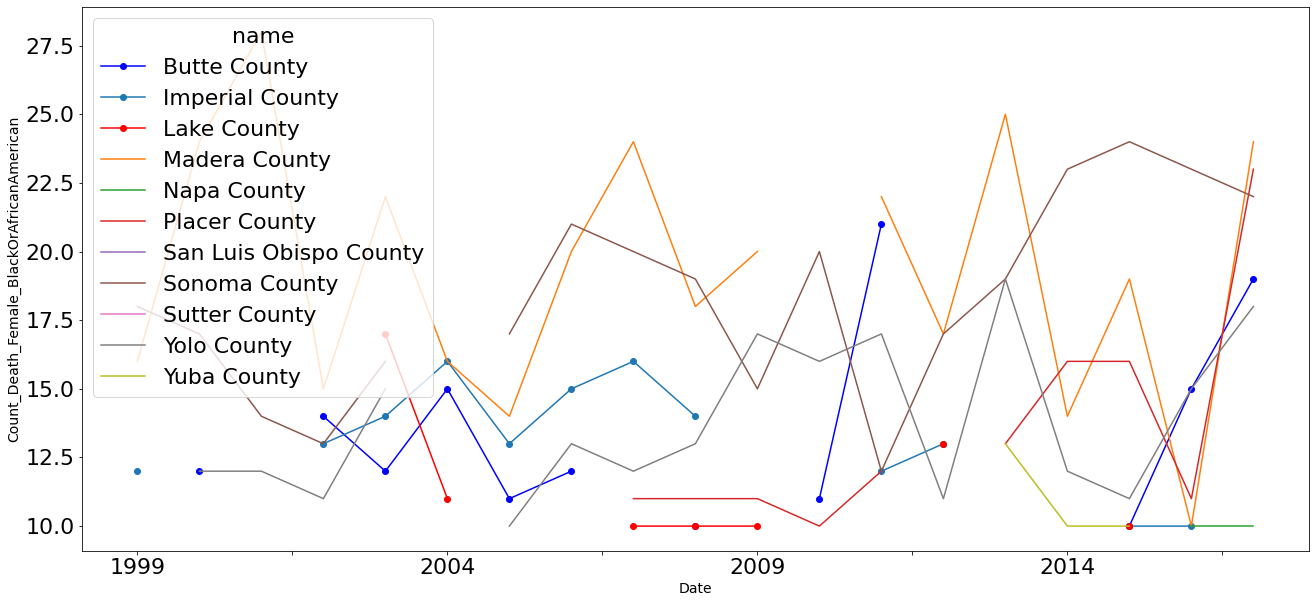

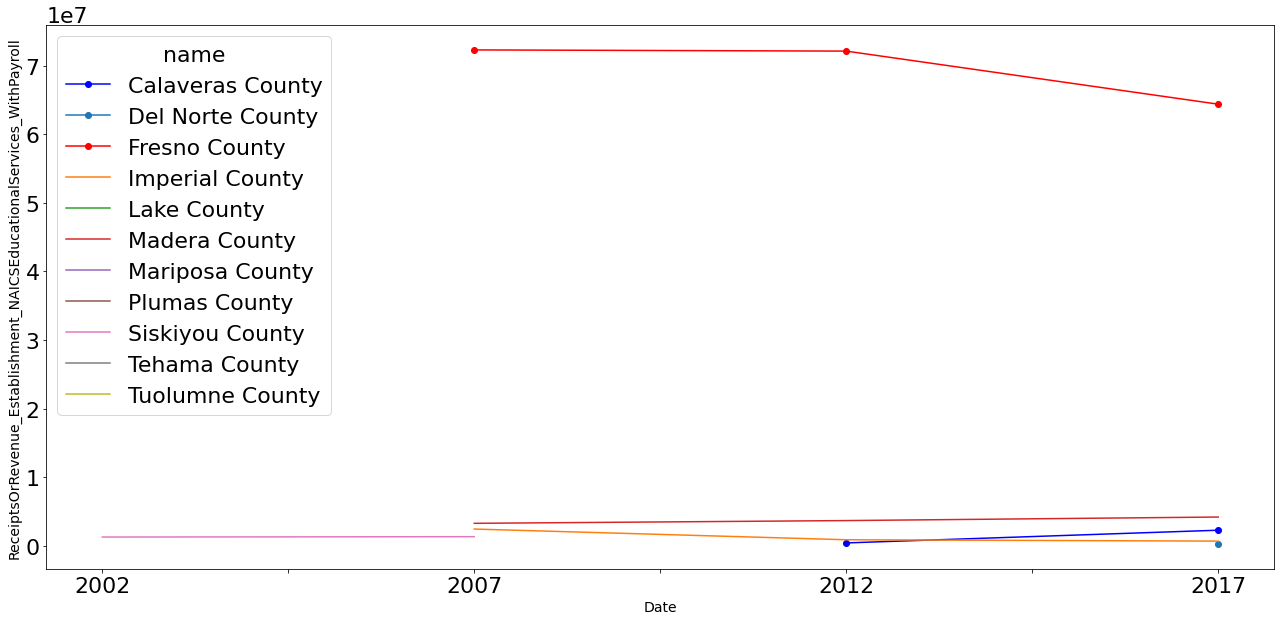

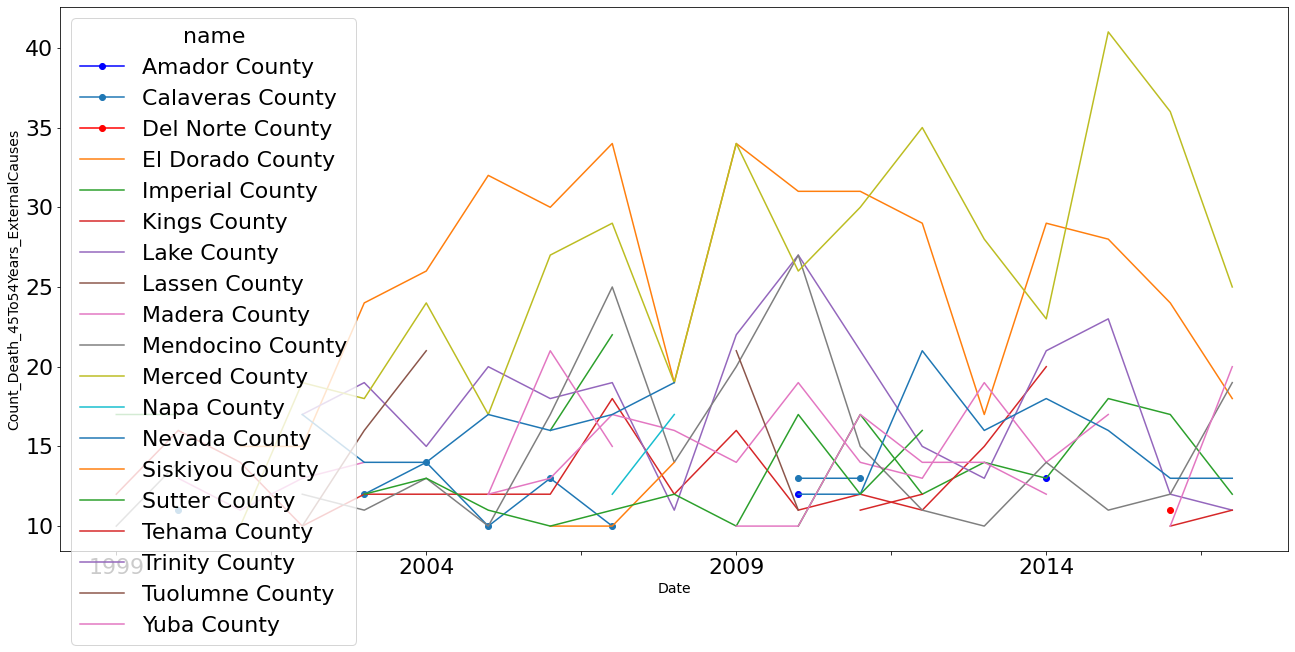

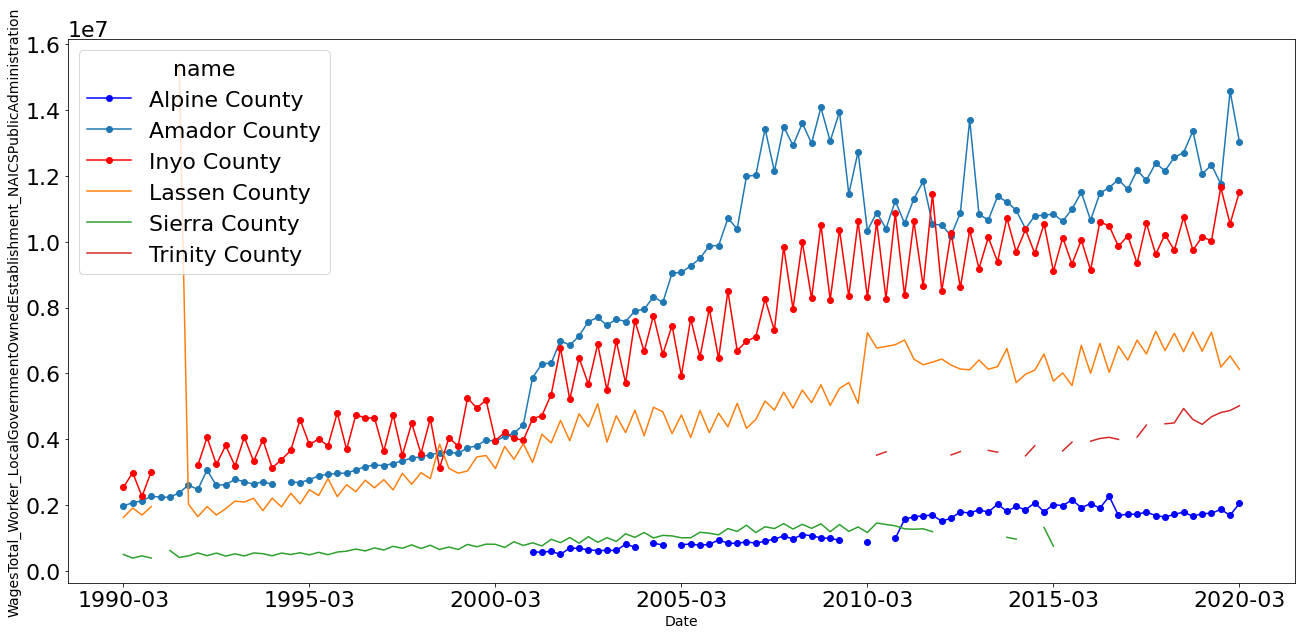

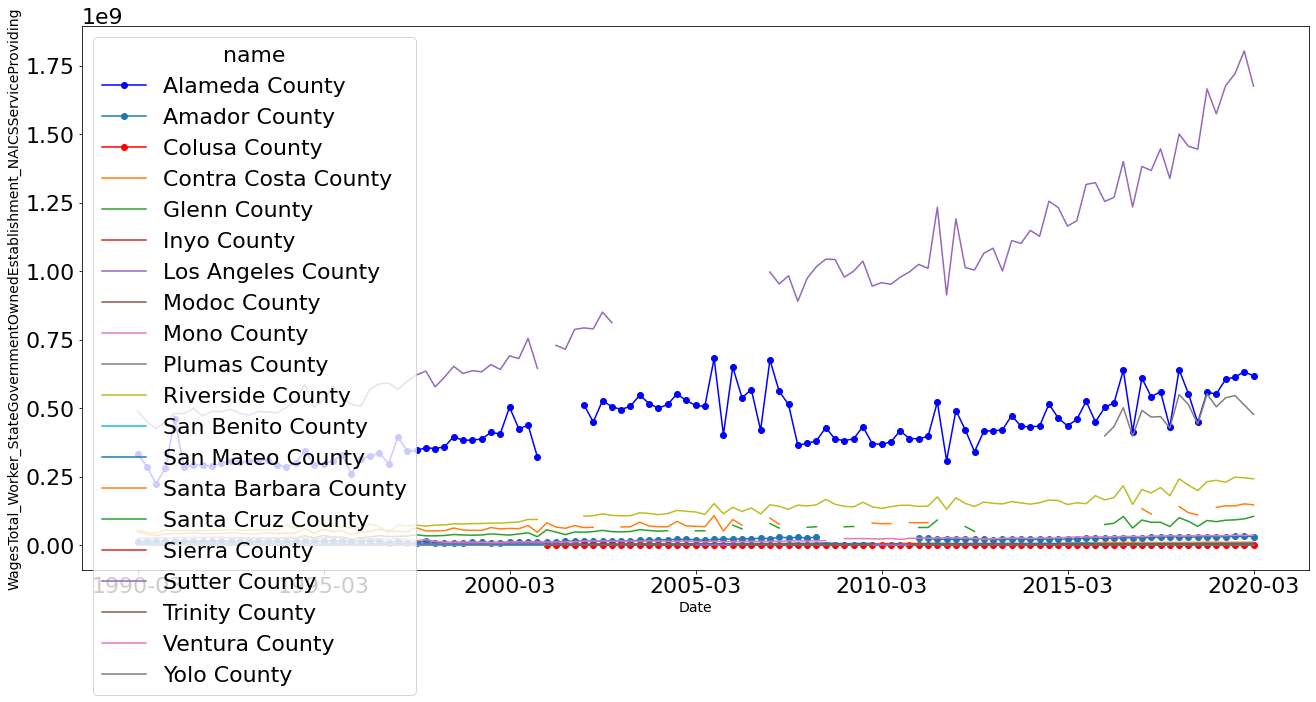

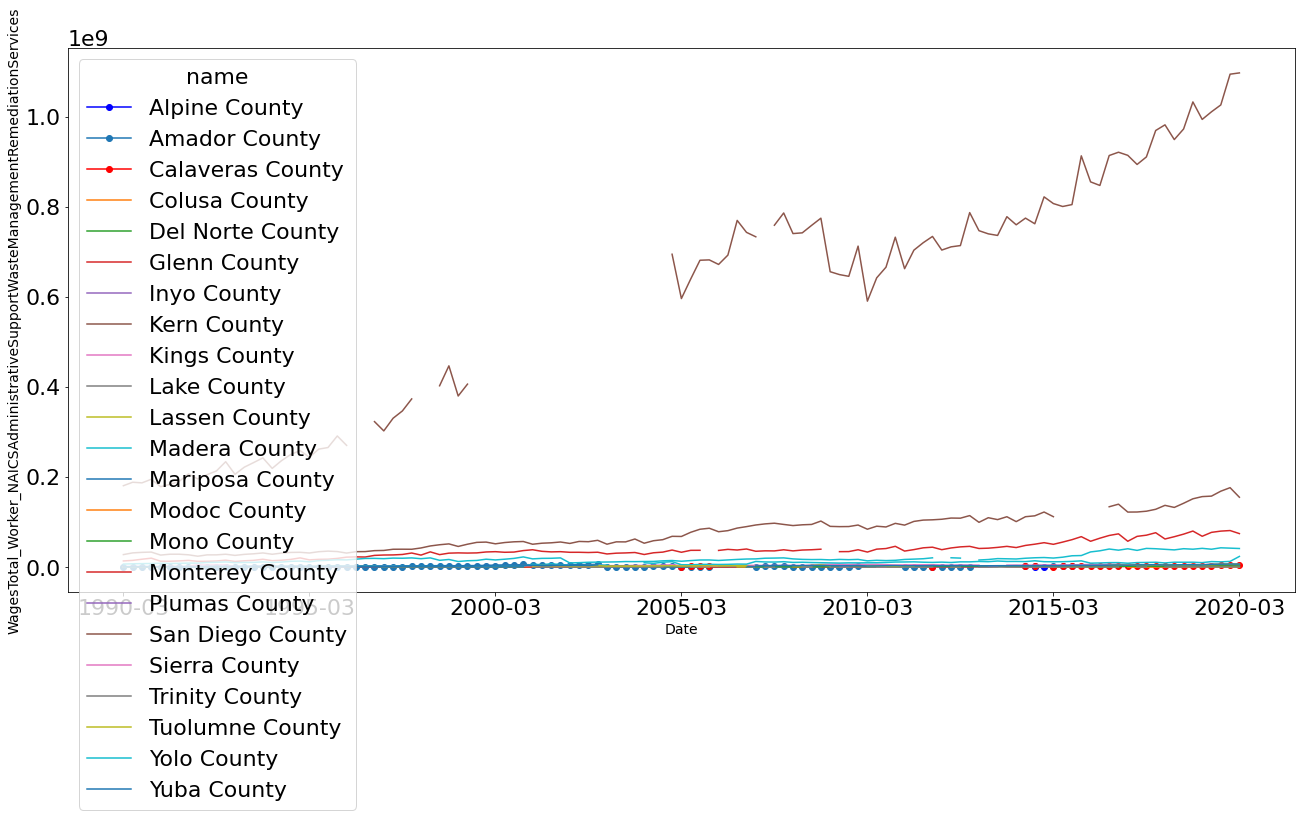

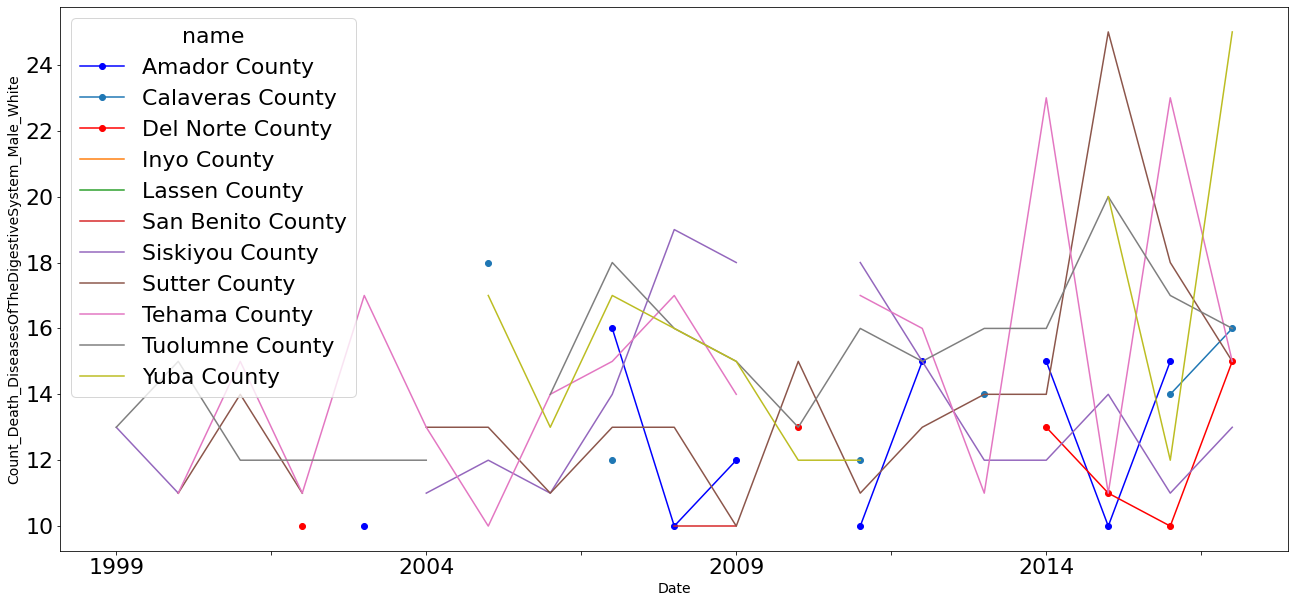

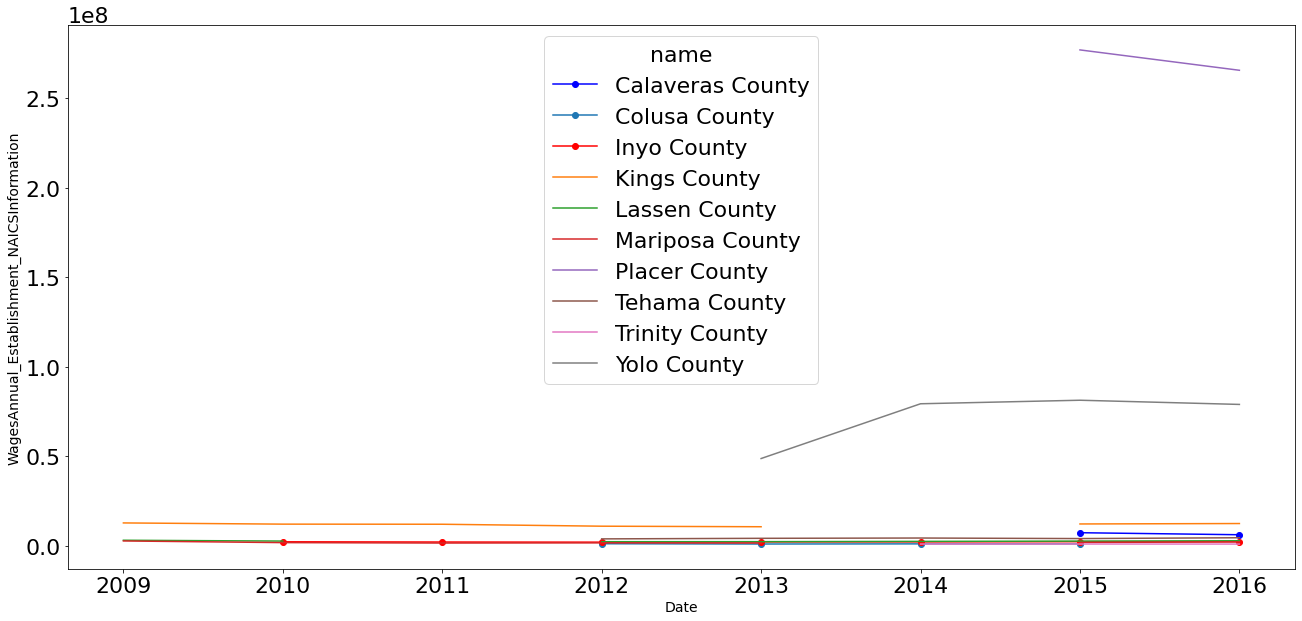

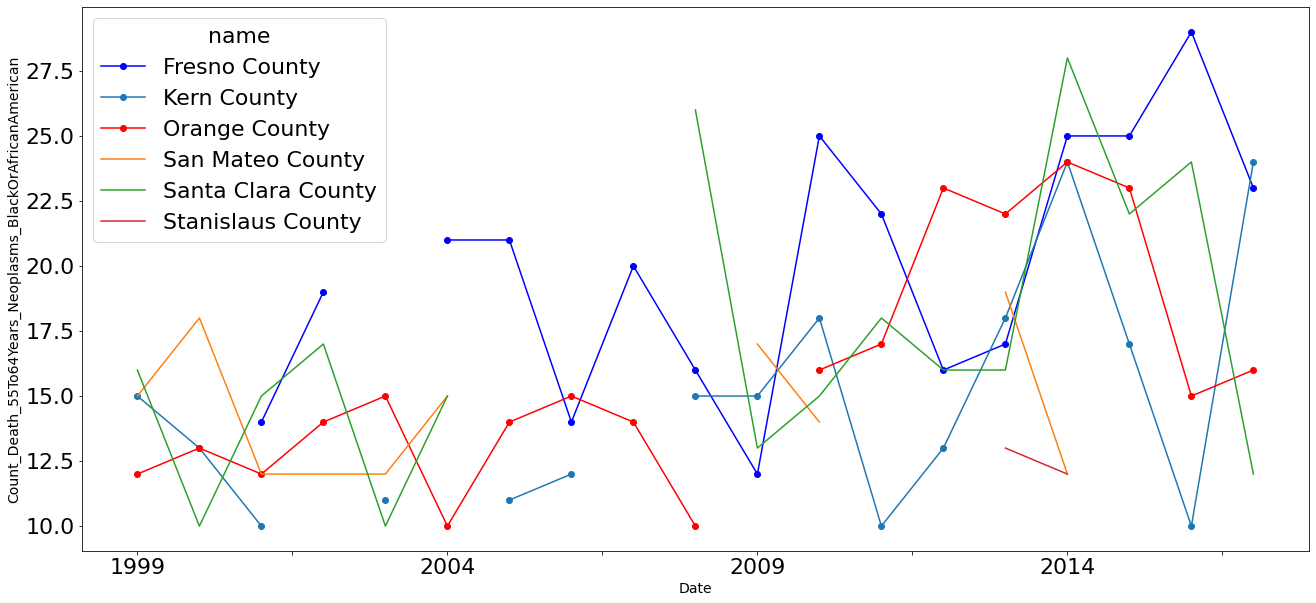

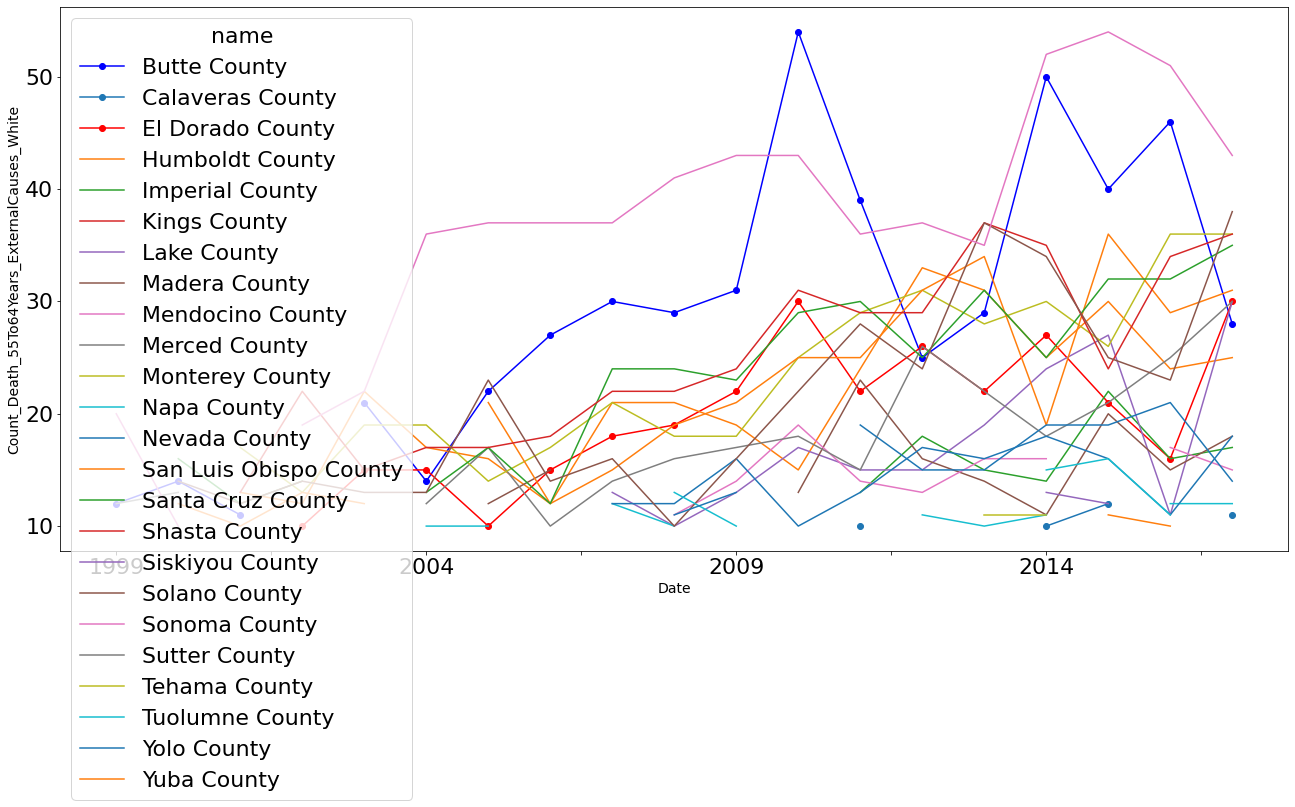

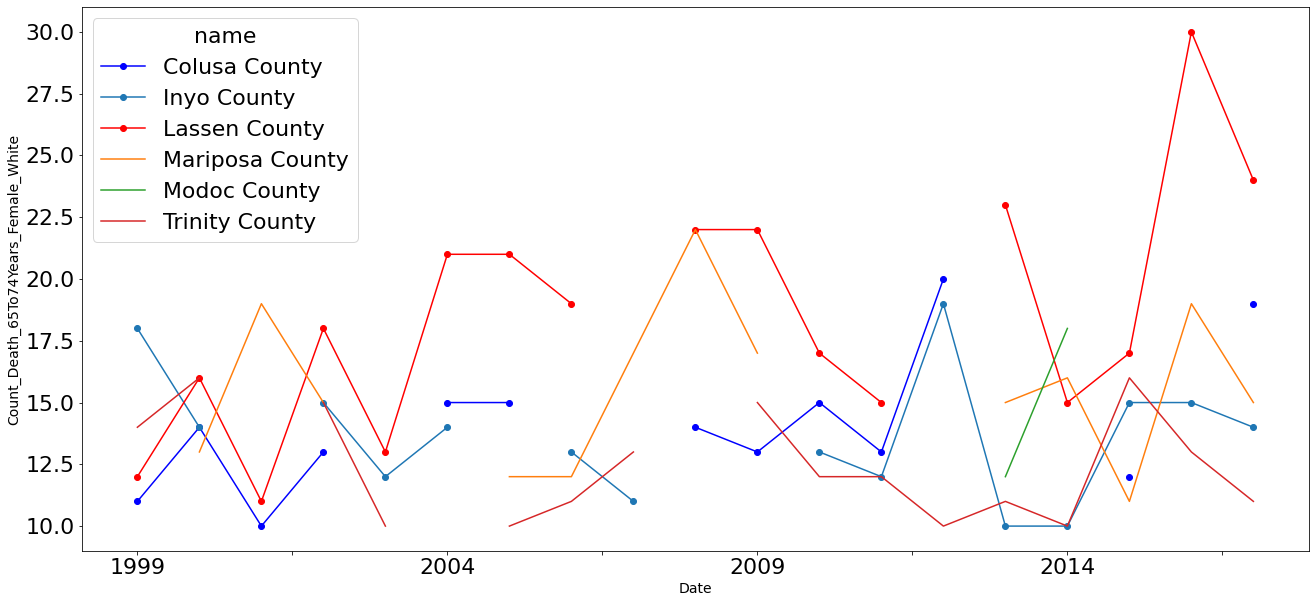

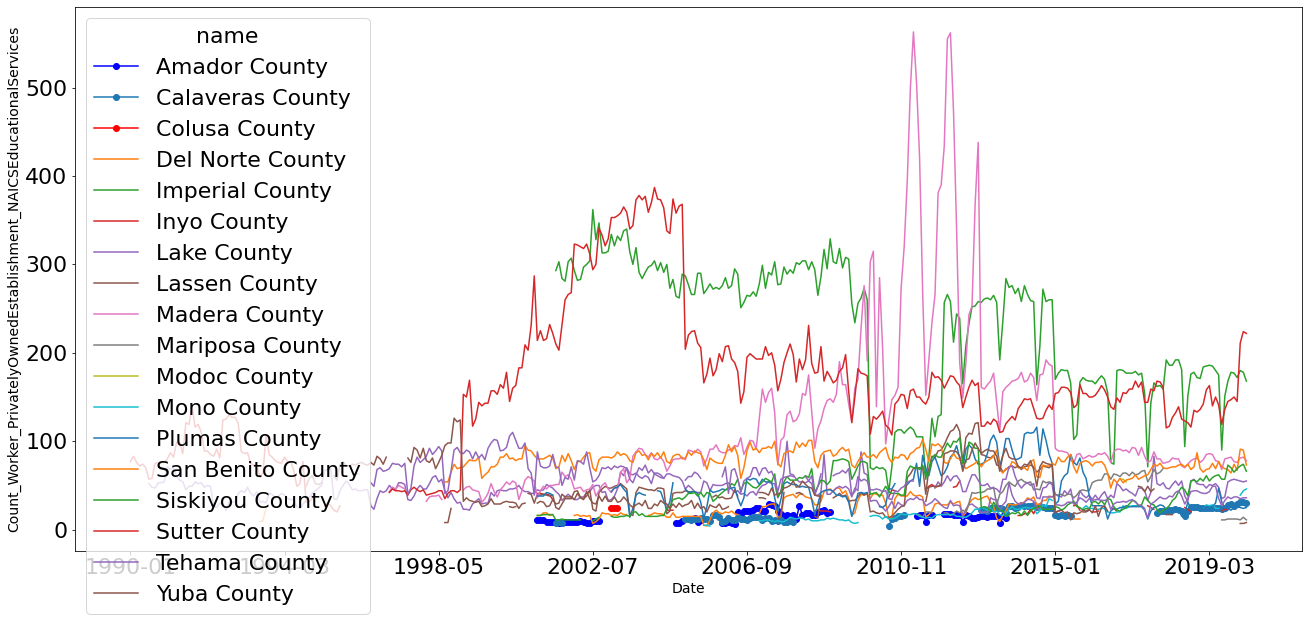

In [4]:
#@title Select a state to plot { run: "auto" }
state_name = "California" #@param ["Missouri", "Arkansas", "Arizona", "Ohio", "Connecticut", "Vermont", "Illinois", "South Dakota", "Iowa", "Oklahoma", "Kansas", "Washington", "Oregon", "Hawaii", "Minnesota", "Idaho", "Alaska", "Colorado", "Delaware", "Alabama", "North Dakota", "Michigan", "California", "Indiana", "Kentucky", "Nebraska", "Louisiana", "New Jersey", "Rhode Island", "Utah", "Nevada", "South Carolina", "Wisconsin", "New York", "North Carolina", "New Hampshire", "Georgia", "Pennsylvania", "West Virginia", "Maine", "Mississippi", "Montana", "Tennessee", "New Mexico", "Massachusetts", "Wyoming", "Maryland", "Florida", "Texas", "Virginia"]
_PLACE = states.loc[states['name'] == state_name].values[0][1]

# Set the second value to True if you want to plot data for the sampled statistical variable:
random_stats = select_random_statvars(300, plot_flag=True, log_p=False)
print("Number of valid samples: " , len(random_stats), random_stats)

# Part 2: Comparing imputation methods

We will compute approximate values for missing values in the time series. This is called [imputation](https://en.wikipedia.org/wiki/Imputation_(statistics)). We can calculate the imputation accuracy by comparing the imputed values with real values. Although in practice we don't hold the original values, we can determine the accuracy by artificial missing points. 

When sampling in Part 1, we made sure to only keep statistical variables for which some counties had time series holes, and some did not.

In this step, we're going to utilize the counties with no missing values. We will artificially remove some of the dates and use the imputation methods to fill them. Then, we can compute the accuracy of each imputation method by comparing with the original (removed) values. Note that we want to compare the $R^2$ scores of different imputation methods and it's crucial to use 
the same set of missing points for all of methods. 

In this notebook, the $R^2$ score $\in [-\infty , 1]$. Higher $R^2$ scores denote higher accuracy imputation. 


You can learn more about $R^2$ score in [Coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination). In short:

$$ R^2 = 1- \frac{\sum{(y_i - f_i)^2}}{{\sum{(y_i - mean)^2}}} = 1- \frac{\sum{(err)^2}}{{\sum{(y_i - mean)^2}}} $$

where $y_i$s are the actual values and $f_i$ are the imputed ones. $mean = \frac{1}{n} \sum{y_i} $.

In [5]:
_METHODS = ["Mean", "Median", "Spline_d1", "Spline_d2", "Spline_d3", "Spline_d4", 
            "Time", "Spline_d5", "InterpolateLinear", "Pchip", "Krogh", "InterpolateAkima"]

import warnings; warnings.simplefilter('ignore')
score = artificial_score_generator(random_stats, quiet=True)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
score

,method,Average of 20 rounds for Count_Establishment_PrivatelyOwnedEstablishment_NAICSHealthCareSocialAssistance,Average of 20 rounds for Count_Death_55To64Years_ExternalCauses,Average of 20 rounds for Count_Death_Female_BlackOrAfricanAmerican,Average of 20 rounds for ReceiptsOrRevenue_Establishment_NAICSEducationalServices_WithPayroll,Average of 20 rounds for Count_Death_45To54Years_ExternalCauses,Average of 20 rounds for WagesTotal_Worker_LocalGovernmentOwnedEstablishment_NAICSPublicAdministration,Average of 20 rounds for WagesTotal_Worker_StateGovernmentOwnedEstablishment_NAICSServiceProviding,Average of 20 rounds for WagesTotal_Worker_NAICSAdministrativeSupportWasteManagementRemediationServices,Average of 20 rounds for Count_Death_DiseasesOfTheDigestiveSystem_Male_White,Average of 20 rounds for WagesAnnual_Establishment_NAICSInformation,Average of 20 rounds for Count_Death_55To64Years_Neoplasms_BlackOrAfricanAmerican,Average of 20 rounds for Count_Death_55To64Years_ExternalCauses_White,Average of 20 rounds for Count_Death_65To74Years_Female_White,Average of 20 rounds for Count_Worker_PrivatelyOwnedEstablishment_NAICSEducationalServices
0,InterpolateLinear,1.00,0.94,0.82,-2.17,0.83,0.99,0.99,0.99,0.76,0.81,0.82,0.94,0.83,0.99
1,Spline_d1,1.00,0.93,0.80,0.64,0.80,0.99,0.99,0.99,0.73,0.72,0.78,0.93,0.81,0.99
2,Time,1.00,0.94,0.82,-2.17,0.83,0.99,0.99,0.99,0.76,0.81,0.82,0.94,0.83,0.99
3,Pchip,1.00,0.86,0.70,-2.17,0.25,0.98,0.98,0.98,0.21,0.64,0.48,0.89,0.63,0.99
4,Spline_d2,0.82,-0.12,0.12,0.29,-3.07,0.97,0.98,0.98,-2.16,0.46,0.00,-0.48,-0.52,0.93
5,Mean,0.80,0.76,0.77,0.57,0.76,0.80,0.80,0.80,0.77,0.67,0.75,0.76,0.77,0.80
6,Median,0.75,0.75,0.75,0.57,0.76,0.79,0.78,0.80,0.76,0.64,0.73,0.74,0.76,0.79
7,InterpolateAkima,-16.55,-16.84,-21.11,-2.17,-19.71,-18.43,-20.85,-18.20,-20.61,-23.46,-21.87,-23.04,-18.73,-20.33
8,Krogh,-16.55,-101.00,-101.00,-2.17,-101.00,-18.43,-20.86,-18.20,-101.00,-27.14,-101.00,-101.00,-101.00,-20.34
9,Spline_d5,-101.00,-101.00,-101.00,-2.17,-101.00,-4.25,-0.67,-2.45,-101.00,-27.14,-101.00,-101.00,-101.00,-101.00


You can sort the above **`score`** table by different statistical variables. The current table is sorted by $R^2$ values of the first variable.  

# Conclusion

In this notebook, we used Data Commons to survey the missing value patterns across different time series. In our experiments, a time series might have random disjoint missing values, a missing interval (consecutive dates), or even multiple missing intervals. 


We used cross-validation to evaluate multiple imputation methods. The method with the highest $R^2$ score may differ by time series. Although the best method might change across runs, in our experiments, we observed that in most cases **time**, **interpolate linear**, **mean**, and **median** perform well. Note that the linear method "ignores the index and treat the values as equally spaced." ([pandas.Series.interpolate](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.interpolate.html)) thus, for equally spaced data series time and linear will have the same result. 

While performing imputation, we recommend to avoid any method with a negative score for a time series.